In [2]:
import pandas as pd 
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
close_prices = pd.read_csv('../data/processed_data.csv', index_col='Date',
                           parse_dates=True)
print(close_prices)
tsla_prices = close_prices[['TSLA']].copy()
print(tsla_prices)

                  BND         SPY        TSLA
Date                                         
2015-07-01  60.816719  174.917130   17.943333
2015-07-02  60.967091  174.756958   18.667999
2015-07-06  61.177593  174.259644   18.648001
2015-07-07  61.237736  175.355484   17.858667
2015-07-08  61.410656  172.413498   16.997334
...               ...         ...         ...
2025-07-24  72.698860  634.419983  305.299988
2025-07-25  72.878265  637.099976  316.059998
2025-07-28  72.758659  636.940002  325.589996
2025-07-29  73.137398  635.260010  321.200012
2025-07-30  72.948036  634.460022  319.040009

[2535 rows x 3 columns]
                  TSLA
Date                  
2015-07-01   17.943333
2015-07-02   18.667999
2015-07-06   18.648001
2015-07-07   17.858667
2015-07-08   16.997334
...                ...
2025-07-24  305.299988
2025-07-25  316.059998
2025-07-28  325.589996
2025-07-29  321.200012
2025-07-30  319.040009

[2535 rows x 1 columns]


In [4]:
split_date = '2023-12-31'

train_data = tsla_prices.loc[tsla_prices.index <= split_date]
test_data = tsla_prices.loc[tsla_prices.index > split_date]

print(f"Training data points: {len(train_data)}")
print(f"Testing data points: {len(test_data)}")

Training data points: 2140
Testing data points: 395


In [5]:
warnings.filterwarnings('ignore')

Building and fitting the Holt's Linear Trend model...

Holt's Model Summary:
                              Holt Model Results                              
Dep. Variable:                   TSLA   No. Observations:                 2140
Model:                           Holt   SSE                          73735.256
Optimized:                       True   AIC                           7582.905
Trend:                 Multiplicative   BIC                           7605.579
Seasonal:                        None   AICC                          7582.944
Seasonal Periods:                None   Date:                 Wed, 13 Aug 2025
Box-Cox:                        False   Time:                         16:17:35
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9708176                al

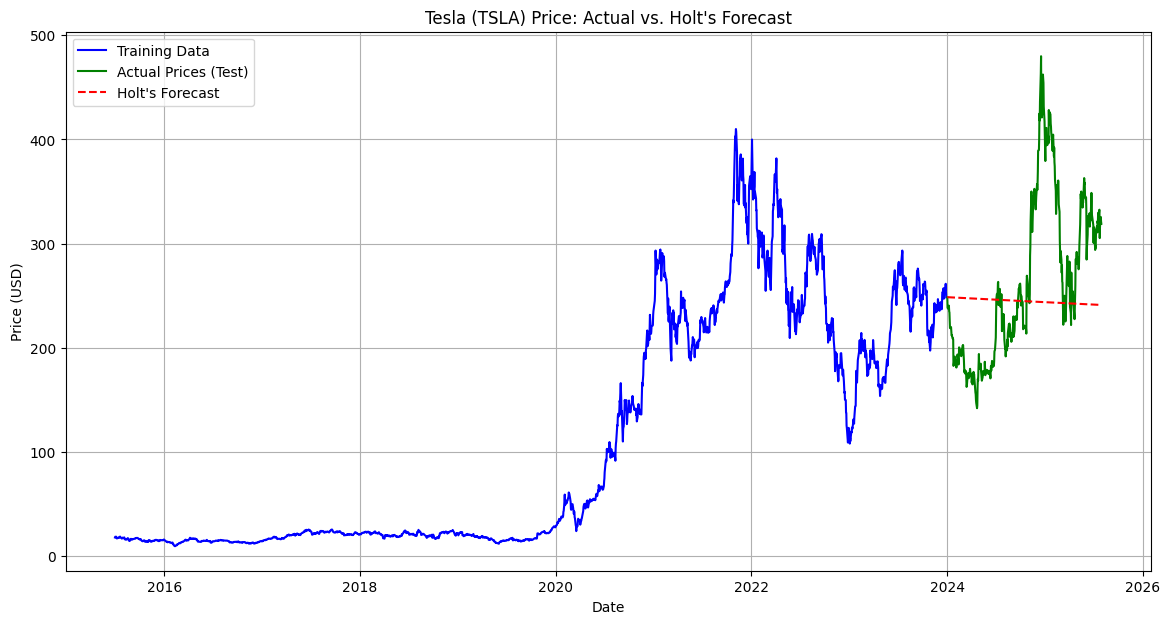

In [12]:
from statsmodels.tsa.api import Holt
import matplotlib.pyplot as plt

print("Building and fitting the Holt's Linear Trend model...")

holt_model = Holt(train_data['TSLA'], exponential=True, initialization_method="estimated")

# Fit the model
holt_fit = holt_model.fit()

print("\nHolt's Model Summary:")
print(holt_fit.summary())

# Forecast for the same number of periods as the test set
holt_forecasts_series = holt_fit.forecast(len(test_data))
forecast_values = holt_forecasts_series.values
# Assign these values directly to the new column. Pandas will align them positionally.
test_data['Holt_Forecast'] = forecast_values
# --- END OF FIX ---


print("\nForecasting complete. Test data now includes Holt's forecast:")
print(test_data.head()) # This should now show proper numerical values

# Let's quickly visualize the forecast against the actual data to be sure
plt.figure(figsize=(14, 7))
plt.plot(train_data['TSLA'], label='Training Data', color='blue')
plt.plot(test_data['TSLA'], label='Actual Prices (Test)', color='green')
plt.plot(test_data['Holt_Forecast'], label='Holt\'s Forecast', color='red', linestyle='--')
plt.title('Tesla (TSLA) Price: Actual vs. Holt\'s Forecast')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [15]:
scaled_train_data = scaler.fit_transform(train_data[['TSLA']])

In [16]:
scaled_test_data = scaler.transform(test_data[['TSLA']])

print(f"Original min price in training data: {train_data['TSLA'].min()}")
print(f"Original max price in training data: {train_data['TSLA'].max()}")
print(f"Scaled training data min: {scaled_train_data.min()}")
print(f"Scaled training data max: {scaled_train_data.max()}")

Original min price in training data: 9.57800006866455
Original max price in training data: 409.9700012207031
Scaled training data min: 0.0
Scaled training data max: 1.0


In [17]:
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, 0])
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)


In [18]:
look_back = 60

# Create the training sequences from the scaled data
X_train, y_train = create_dataset(scaled_train_data, look_back)

# The Keras LSTM layer needs data in a specific 3D format:
# [number_of_samples, number_of_timesteps, number_of_features]
# So, we reshape X_train.
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [19]:
print(f"Shape of X_train (samples, timesteps, features): {X_train.shape}")
print(f"Shape of y_train (labels): {y_train.shape}")

Shape of X_train (samples, timesteps, features): (2080, 60, 1)
Shape of y_train (labels): (2080,)


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [21]:
lstm_model = Sequential()

# layer 1
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dropout(0.2)) # Adds regularization

# Layer 2
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dropout(0.2))

# Output Layer
lstm_model.add(Dense(units=1))

# Compile the model, defining the optimizer and loss function
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Print a summary of our model's architecture
lstm_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
print("\nTraining LSTM model...")
history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)
print("LSTM model training complete.")


Training LSTM model...
Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - loss: 0.0118
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 0.0029
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 0.0026
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - loss: 0.0025
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 0.0022
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0021
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0019
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0018
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 0.0017
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0018
Epoch 11/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0016
Epoch 12/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0014
Epoch 13/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.0014
Epoch 14/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.0016
Epoch 15/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 84

In [32]:
# ===================================================================
# REPLACEMENT FOR SECTION 3.4: Generate Predictions with the LSTM (FIXED)
# ===================================================================

print("\nGenerating predictions with LSTM model...")

# 1. Create the input data for prediction
# We need the last 'look_back' days from the training set to predict the first day of the test set.
# So, our input block starts there and includes all of the test data.
input_data = tsla_prices[len(train_data) - look_back:].values

# 2. Scale this input data using the same scaler as before
scaled_input_data = scaler.transform(input_data)

# 3. Create the test sequences (X_test)
X_test = []
# We loop from 'look_back' to the end of our input data block
# This will create exactly len(test_data) sequences
for i in range(look_back, len(scaled_input_data)):
    X_test.append(scaled_input_data[i-look_back:i, 0])

# Convert X_test to a numpy array and reshape for the model
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 4. Make predictions
lstm_scaled_predictions = lstm_model.predict(X_test)

# 5. Inverse transform the predictions to get actual dollar values
lstm_predictions = scaler.inverse_transform(lstm_scaled_predictions)

# 6. Assign the predictions to the DataFrame
# The lengths should now match perfectly.
if len(lstm_predictions) == len(test_data):
    test_data['LSTM_Predictions'] = lstm_predictions
    print("LSTM Predictions successfully generated and added to test data.")
else:
    # This else block should not be triggered now, but it's good practice to keep it for debugging
    print(f"Prediction length mismatch! Predictions: {len(lstm_predictions)}, Test Data: {len(test_data)}")

print("\nTest data with Holt's and LSTM predictions:")
print(test_data.head())


Generating predictions with LSTM model...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
LSTM Predictions successfully generated and added to test data.

Test data with Holt's and LSTM predictions:
                  TSLA  Holt_Forecast  LSTM_Predictions
Date                                                   
2024-01-02  248.419998     248.604213        252.853134
2024-01-03  238.449997     248.584955        250.898819
2024-01-04  237.929993     248.565697        247.211929
2024-01-05  237.490005     248.546442        243.040421
2024-01-08  240.449997     248.527187        239.152176


In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Evaluation for Holt's Linear Trend Model ---
holt_mae = mean_absolute_error(test_data['TSLA'], test_data['Holt_Forecast'])
holt_rmse = np.sqrt(mean_squared_error(test_data['TSLA'], test_data['Holt_Forecast']))
print(holt_rmse)
holt_mape = np.mean(np.abs((test_data['TSLA'] - test_data['Holt_Forecast']) / test_data['TSLA'])) * 100

80.14870297944606


In [39]:
# --- Evaluation for LSTM Model ---
# Ensure there are no NaNs in the prediction column before calculating
test_data.dropna(subset=['LSTM_Predictions'], inplace=True)
lstm_mae = mean_absolute_error(test_data['TSLA'], test_data['LSTM_Predictions'])
lstm_rmse = np.sqrt(mean_squared_error(test_data['TSLA'], test_data['LSTM_Predictions']))
print(lstm_rmse)
lstm_mape = np.mean(np.abs((test_data['TSLA'] - test_data['LSTM_Predictions']) / test_data['LSTM_Predictions'])) * 100

17.756361634291977


In [35]:
print("\n--- Model Performance Comparison ---")
print(f"Holt's Model MAE:  ${holt_mae:.2f}")
print(f"Holt's Model RMSE: ${holt_rmse:.2f}")
print(f"Holt's Model MAPE: {holt_mape:.2f}%")
print("-" * 20)
print(f"LSTM Model MAE:  ${lstm_mae:.2f}")
print(f"LSTM Model RMSE: ${lstm_rmse:.2f}")
print(f"LSTM Model MAPE: {lstm_mape:.2f}%")
print("-" * 20)


--- Model Performance Comparison ---
Holt's Model MAE:  $64.55
Holt's Model RMSE: $80.15
Holt's Model MAPE: 24.41%
--------------------
LSTM Model MAE:  $12.67
LSTM Model RMSE: $17.76
LSTM Model MAPE: 4.84%
--------------------


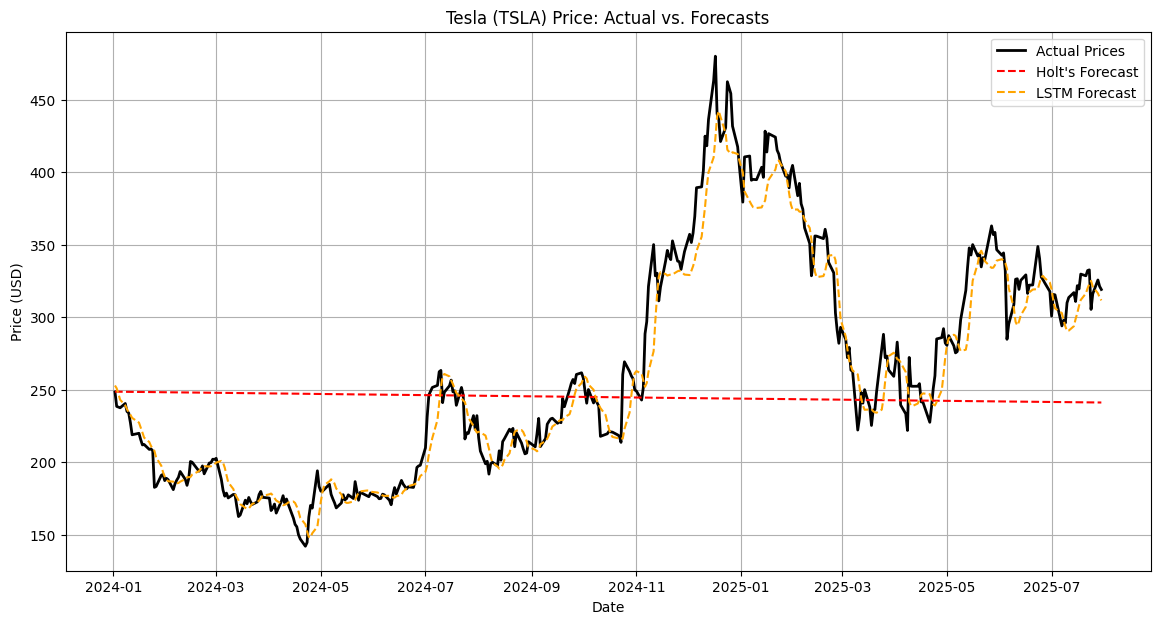

In [36]:
plt.figure(figsize=(14, 7))
plt.plot(test_data['TSLA'], label='Actual Prices', color='black', linewidth=2)
plt.plot(test_data['Holt_Forecast'], label='Holt\'s Forecast', color='red', linestyle='--')
plt.plot(test_data['LSTM_Predictions'], label='LSTM Forecast', color='orange', linestyle='--')
plt.title('Tesla (TSLA) Price: Actual vs. Forecasts')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
# Save the trained LSTM model
lstm_model.save('lstm_tesla_forecaster.h5') 

# Save the scaler object
import pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    
print("LSTM Model and Scaler have been saved to files.")

LSTM Model and Scaler have been saved to files.
